## Table Of Content
1. [Libraries](#libraries)
2. [Data](#data)
3. [Data Dictionary](#dictionary)
4. [Data Inspection](#inspection)
5. [Data Cleaning](#clean)
6. [Feature engineering](#fe)
7. [Explortatory Data Analysis](#eda)
8. [Modelling](#model)
9. [Testing](#testing)

<a name="libraries"><a/>
## 1. Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from plotnine import *

from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

In [2]:
# Custom Functions
import functions as custom

In [3]:
pd.options.display.float_format = '{:.5f}'.format

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

<a name="data"><a/>
## 2. Data

In [4]:
# Load files
train = pd.read_csv('train.csv', parse_dates = ['Datetime'])
test = pd.read_csv('test.csv', parse_dates = ['Datetime'])
samplesubmission = pd.read_csv('SampleSubmission.csv')

<a name="dictionary"><a/>
## 3. Data Dictionary

**Sensor1_PM2.5, Sensor2_PM2.5 ::** These are recorded PM2.5 from Sensor 1 and Sensor 2.   
PM2.5 also called Fine particulate matter are tiny particles in the air that reduce visibility and cause the air to appear hazy when levels are elevated. (PM2.5 are complex because they can be made up of numerous types of chemicals and particles and they can be partly liquid. mesured in micrograms per cubic meter.
Note(A microgram is a unit of weight. there are a million micrograms in a gram, & a pound = 450 grams.  
  
**Temparature ::** This is the degree or indensity of heat present when each PM2.5 was recorded using Celsius scale.  
higher tempemperature leads to low air quality. when weather is hot primary sources of pollutants tend to increase.

**Relative_Humidity ::** Relative humidity is the amount of water vapor actually in the air, expressed as a percentage of the maximum amount of water vapor the air can hold at the same temperature. at a certain temperature the ralative humidity is how much water vapor the air can hold.  
High humidity increases the rate of harmful or toxic chemicals in the air.  

<a name="inspection"><a/>
## 4. Data Inspection
1. [Missing Values](#missing)
2. [Duplicates](#duplicate)
3. [Outliers](#outlier)

In [5]:
train.head(3)

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault
0,ID_QF0ZTQJ2SF5Q,2021-11-03 04:06:31,52.58000,49.52000,17.40000,96.00000,0
1,ID_4GTK689CNX5S,2021-11-08 18:43:23,35.25000,33.40000,25.00000,75.00000,0
2,ID_DL7VVKW9U7XQ,2021-11-07 09:50:33,19.18000,23.50000,24.90000,75.00000,0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297177 entries, 0 to 297176
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   ID                 297177 non-null  object        
 1   Datetime           297177 non-null  datetime64[ns]
 2   Sensor1_PM2.5      293563 non-null  float64       
 3   Sensor2_PM2.5      293563 non-null  float64       
 4   Temperature        293628 non-null  float64       
 5   Relative_Humidity  293628 non-null  float64       
 6   Offset_fault       297177 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 14.7+ MB


In [7]:
test.head(3)

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity
0,ID_STL3V9B2OU12,2022-01-28 08:49:41,90.75000,114.78000,22.20000,56.00000
1,ID_U2EKAY4SGA94,2022-02-16 21:30:17,56.03000,52.18000,NaN,NaN
2,ID_UJFLEWQR0U4N,2022-01-24 17:57:18,387.35000,346.73000,28.10000,63.00000


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127361 entries, 0 to 127360
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   ID                 127361 non-null  object        
 1   Datetime           127361 non-null  datetime64[ns]
 2   Sensor1_PM2.5      127361 non-null  float64       
 3   Sensor2_PM2.5      127361 non-null  float64       
 4   Temperature        39271 non-null   float64       
 5   Relative_Humidity  39271 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 5.3+ MB


<a name="missing"><a/>
### Missing Values

In [9]:
print(f"Train Set::\n {train.isnull().sum()}\n")

print(f"Test Set ::\n {test.isnull().sum()}")

Train Set::
 ID                      0
Datetime                0
Sensor1_PM2.5        3614
Sensor2_PM2.5        3614
Temperature          3549
Relative_Humidity    3549
Offset_fault            0
dtype: int64

Test Set ::
 ID                       0
Datetime                 0
Sensor1_PM2.5            0
Sensor2_PM2.5            0
Temperature          88090
Relative_Humidity    88090
dtype: int64


In the train Data set there are 3,614 missing values in both Sensor1 and Sensor2 PM2.5, also for both Temperature and Relative Humidity there are 3,549 missing values.   
In the test Data set both Temperature and Relative Humidity have 88,090 missing values.

In [10]:
def related_missing_record(df, cols):
    check_1 = df.loc[df[cols[0]].isna()].loc[df[cols[1]].notna()].shape[0]
    check_2 = df.loc[df[cols[1]].isna()].loc[df[cols[0]].notna()].shape[0]
    return check_1 == check_2

In [11]:
# Are the missing values related by each record
print(f"Both Sensor ::\n {related_missing_record(train, ['Sensor1_PM2.5', 'Sensor2_PM2.5'])}\n")
print(f"Train Temperature & Relative Humidity::\n {related_missing_record(train, ['Temperature', 'Relative_Humidity'])}\n")
print(f"Test Temperature & Relative Humidity::\n {related_missing_record(train, ['Temperature', 'Relative_Humidity'])}")

Both Sensor ::
 True

Train Temperature & Relative Humidity::
 True

Test Temperature & Relative Humidity::
 True


The above analysis shows that records are missing for both sensors in the train set and also for temperature and Relative Humidity.  
The same can be said for temperature and Relative Humidity in the test set.

possible solution will be to drop missing records in the train set.

<a name="duplicate"><a/>
### Duplicates

In [12]:
print(f"Train data set have [{train.duplicated().sum()}] duplicated values")
print(f"Test data set have [{test.duplicated().sum()}] duplicated values")

Train data set have [0] duplicated values
Test data set have [0] duplicated values


<a name="outlier"><a/>
### Outliers

#### Train set

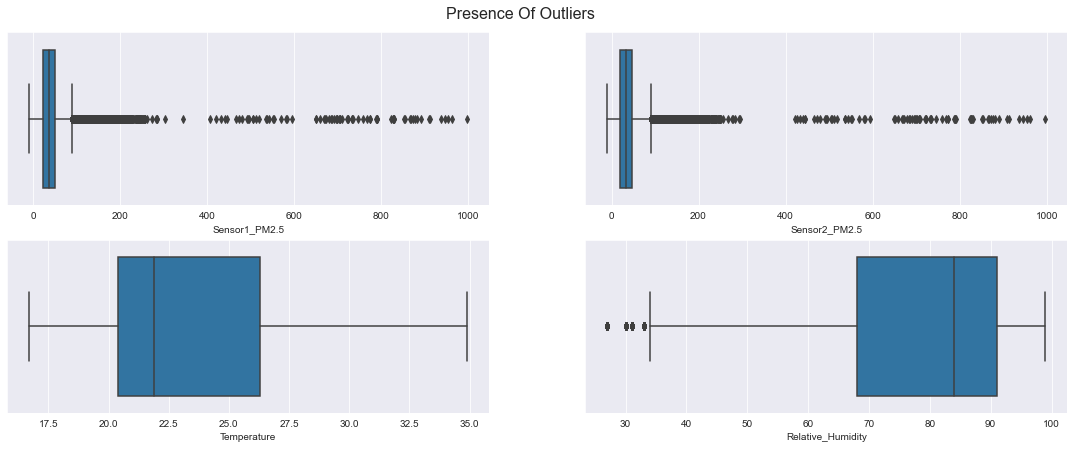

In [13]:
sns.set_style('darkgrid')
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (19, 7))
fig.suptitle('Presence Of Outliers', y = 0.93, fontsize = 16)

for ax, data, name in zip(axes.flatten(), train, ['Sensor1_PM2.5', 'Sensor2_PM2.5', 'Temperature', 'Relative_Humidity']):
    sns.boxplot(train[name], ax = ax)

In [14]:
outlier_cols = ["Sensor1_PM2.5", "Sensor2_PM2.5", "Relative_Humidity"]
for col in outlier_cols:
    print(f"{col} Outlier :: {custom.get_outlier(train, col, 1.5)}")
    print("-"*20)

Sensor1_PM2.5 Outlier :: [-18.055, 89.905]
--------------------
Sensor2_PM2.5 Outlier :: [-22.555000000000003, 89.64500000000001]
--------------------
Relative_Humidity Outlier :: [33.5, 125.5]
--------------------


In [15]:
for col in outlier_cols:
    print(f"Number of Outliers in {col} is {custom.filter_outlier(train, col, 'inner').shape[0]:,}")
    print("-"*46)

Number of Outliers in Sensor1_PM2.5 is 17,402
----------------------------------------------
Number of Outliers in Sensor2_PM2.5 is 15,463
----------------------------------------------
Number of Outliers in Relative_Humidity is 772
----------------------------------------------


In the Train set there are outliers in both type of sensors and also in the relative humidity column.

#### Test Set

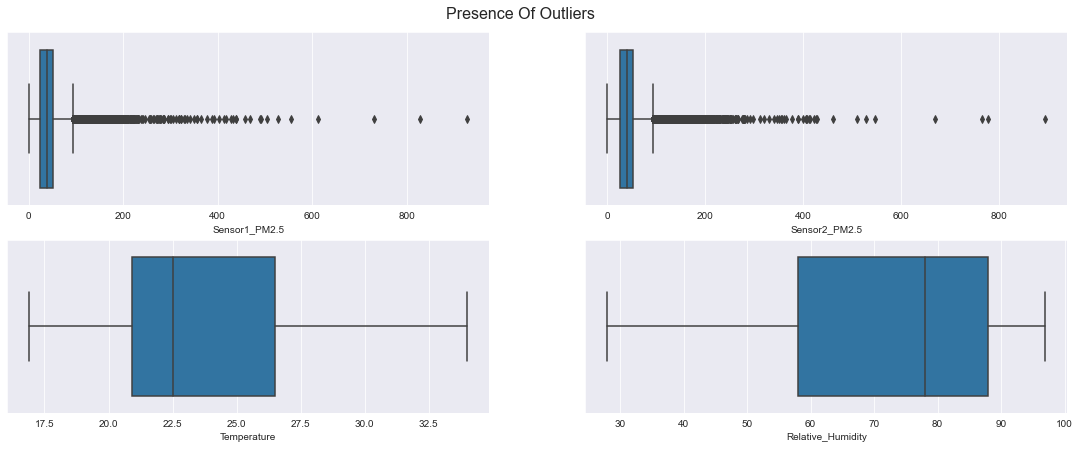

In [16]:
sns.set_style('darkgrid')
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (19, 7))
fig.suptitle('Presence Of Outliers', y = 0.93, fontsize = 16)

for ax, data, name in zip(axes.flatten(), test, ['Sensor1_PM2.5', 'Sensor2_PM2.5', 'Temperature', 'Relative_Humidity']):
    sns.boxplot(test[name], ax = ax)

In [17]:
outlier_cols = ["Sensor1_PM2.5", "Sensor2_PM2.5"]
for col in outlier_cols:
    print(f"{col} Outlier :: {custom.get_outlier(test, col, 1.5)}")
    print("-"*20)

Sensor1_PM2.5 Outlier :: [-16.369999999999997, 93.07]
--------------------
Sensor2_PM2.5 Outlier :: [-15.295000000000002, 93.705]
--------------------


In [18]:
for col in outlier_cols:
    print(f"Number of Outliers in {col} is {custom.filter_outlier(test, col, 'inner').shape[0]:,}")
    print("-"*46)

Number of Outliers in Sensor1_PM2.5 is 6,624
----------------------------------------------
Number of Outliers in Sensor2_PM2.5 is 7,056
----------------------------------------------


In the test set only Sensor1_PM2.5 and Sensor2_PM2.5 have outliers in them.

<a name="clean"><a/>
## 5. Data Cleaning

#### Missing Values

In [19]:
train_c = train.dropna().copy()

<a name="fe"><a/>
## 6. Feature Engineering

In [20]:
train_c = custom.add_pmCategory(train_c)
test_c  = custom.add_pmCategory(test)

In [21]:
train_c = custom.get_standAlone_dates(train_c, "Datetime", ["hour", "month", "year"])
test_c  = custom.get_standAlone_dates(test_c, "Datetime", ["hour", "month", "year"])

<a name="eda"><a/>
## 7. Exploratory Data Analysis
1. [Univariate Analysis](#uni)
2. [Mulivarite Analysis](#multi)
3. [Correlation](#corr)

<a name="uni"><a/>
### Univariate Analysis
1. [Offset fault](#offset_fault)
2. [PM2.5 Sensors](#PM_Sensors)
3. [Temperature](#temperature)
4. [Relative Humidity](#rh)
5. [Datetime](#date)

In [22]:
train_c["faulty"] = train_c["Offset_fault"].replace({0: "No", 1: "Yes"})

<a name="offset_fault"><a/>
#### Offset fault variable

In [23]:
custom.rec_count(train_c, "faulty", typ = "tbl")

,faulty,count
0,No,182863
1,Yes,107151


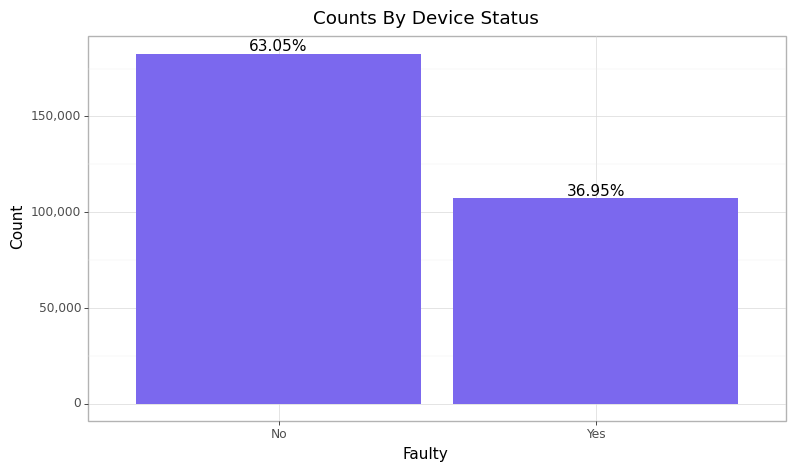

<ggplot: (16103162)>

In [24]:
custom.rec_count(train_c, "faulty", title = "Device Status", typ = "plt")

There are less faulty sensor devices, for our model we will need to take care of this imbalancene using Smote, Oversampling or Undersampling.

<a name="PM_Sensors"><a/>
#### PM2.5 Sensors

In [25]:
train_c[["Sensor1_PM2.5", "Sensor2_PM2.5"]].describe()

,Sensor1_PM2.5,Sensor2_PM2.5
count,290014.00000,290014.00000
mean,40.90204,38.31898
std,28.59837,28.72269
min,-9.45000,-9.70000
25%,22.57000,19.62000
50%,36.65000,33.85000
75%,49.55000,47.70000
max,997.96000,997.26000


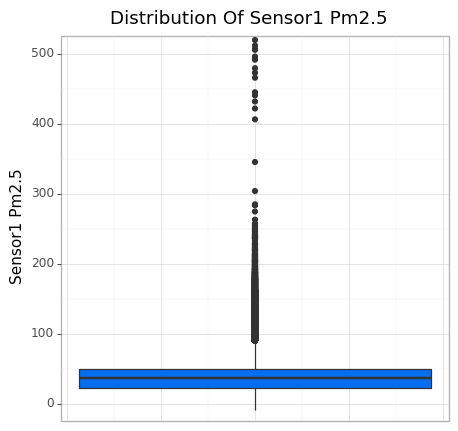

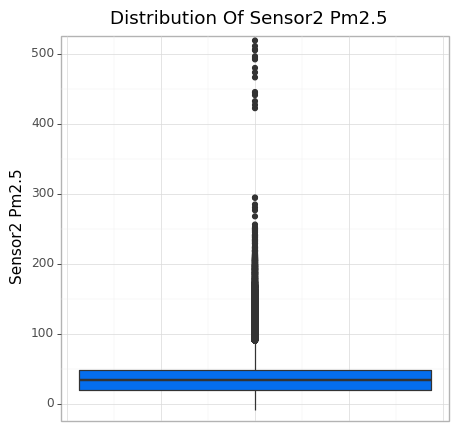

In [26]:
for col in ["Sensor1_PM2.5", "Sensor2_PM2.5"]:
    print(custom.boxPlot(train_c, col, zoom = (0, 500)))

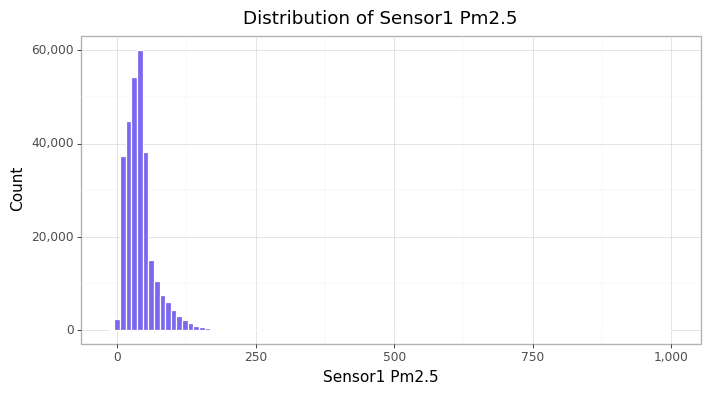

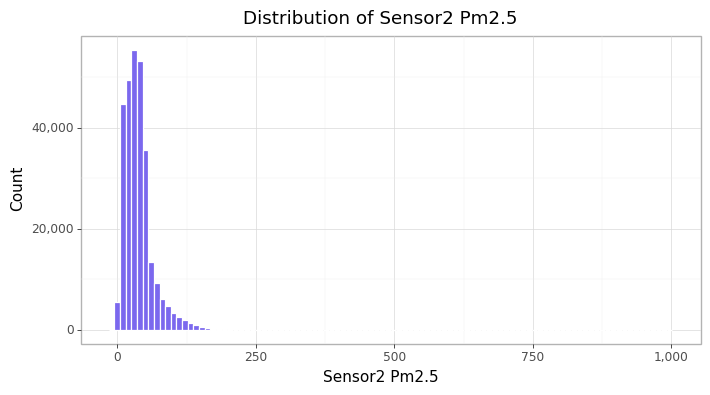

In [27]:
for col in ["Sensor1_PM2.5", "Sensor2_PM2.5"]:
    print(custom.histPlot(train_c, col, bins = 100))

The average particulate matter (PM2.5) for Sensor 1 is 40.9 micrograms per cubic meter and a median of 36.65 micrograms per cubic meter. While for Sensor 2 the average PM2.5 is 38.31 micrograms per cubic meter and a median of 33.85 micrograms per cubic meter.  
   
There are 65 records of PM2.5 above 500 (Hazadious) from sensor 1 and sensor 2.

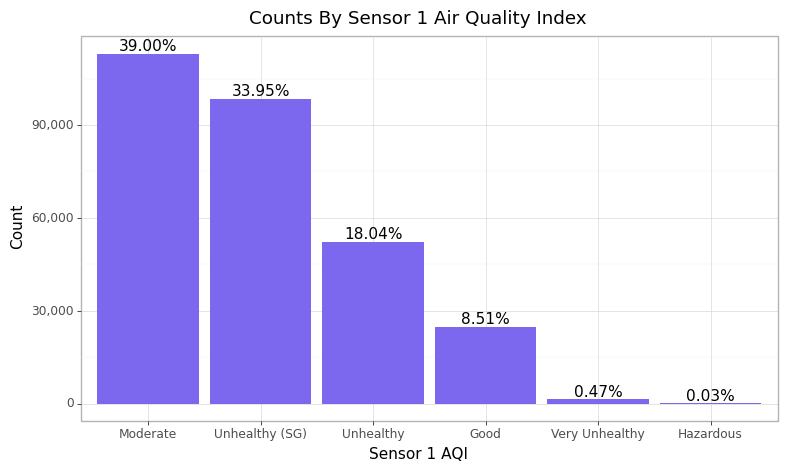

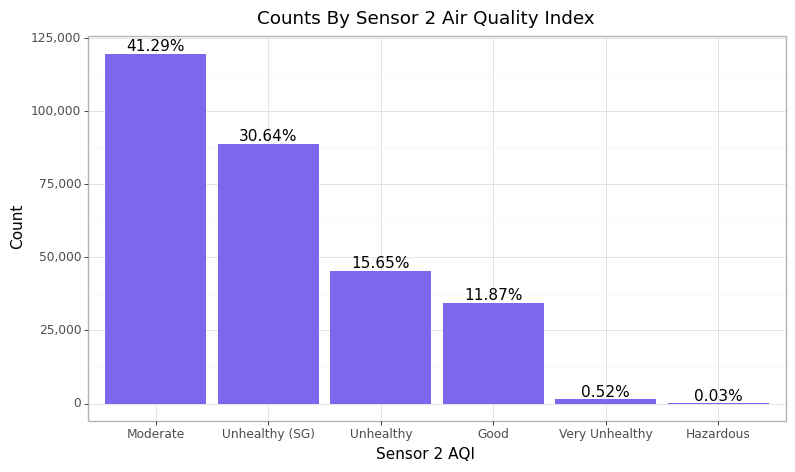

In [28]:
for col, value in zip(["S1_AQI", "S2_AQI"], ["1", "2"]):
    print(custom.rec_count(train_c, col, x_lab = f"Sensor {value} AQI", title = f"Sensor {value} Air Quality Index"))

For both Sensors the recorded Air quality shows that there were more Moderate and unhealthy (for Sensitive group) air quality index, Hazardous and  Very Unhealthy AQI were the least occuring AQI.

<a name="temperature"><a/>
#### Temperature

In [29]:
train_c["Temperature"].describe()

count   290014.00000
mean        23.32274
std          3.84195
min         16.70000
25%         20.40000
50%         21.90000
75%         26.30000
max         34.90000
Name: Temperature, dtype: float64

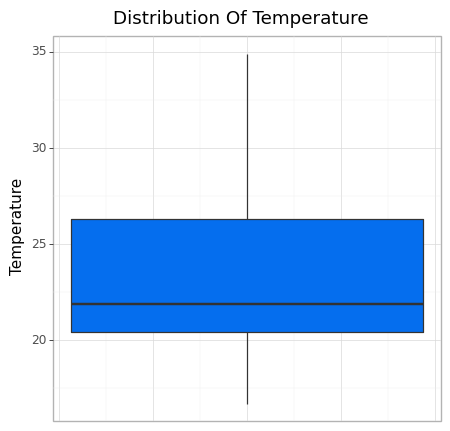

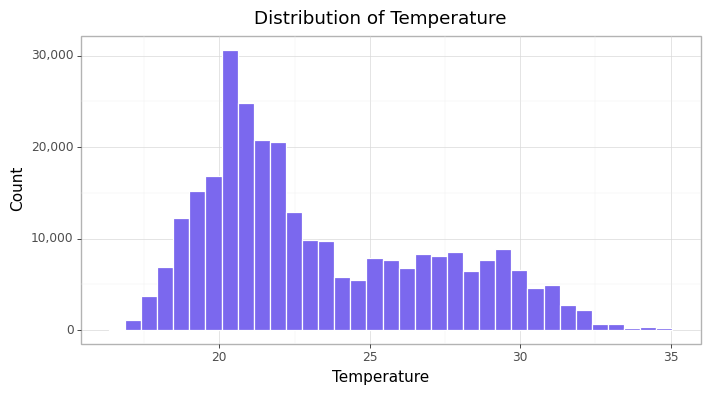

<ggplot: (15899667)>

In [30]:
print(custom.boxPlot(train_c, "Temperature"))
custom.histPlot(train_c, "Temperature", bins = 35)

The Average recorded was 23.32 degrees, there where more low temperatures recorded then high temperatures.

<a name="rh"><a/>
#### Relative Humidity

In [31]:
train_c["Relative_Humidity"].describe()

count   290014.00000
mean        78.61439
std         14.79190
min         27.00000
25%         68.00000
50%         84.00000
75%         91.00000
max         99.00000
Name: Relative_Humidity, dtype: float64

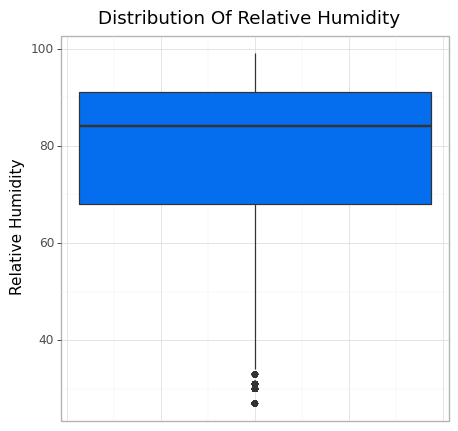

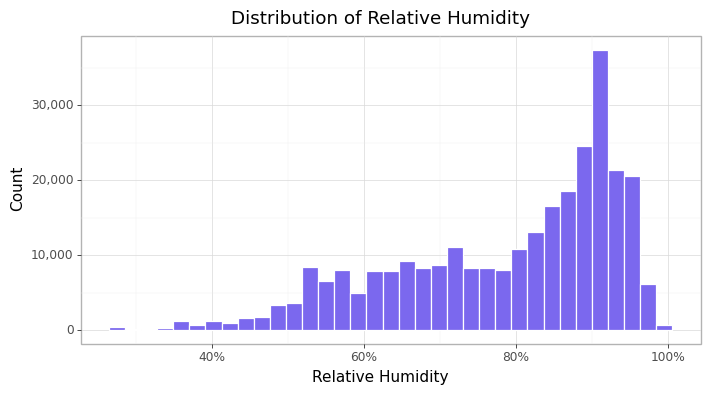

<ggplot: (16083685)>

In [32]:
print(custom.boxPlot(train_c, "Relative_Humidity"))
custom.histPlot(train_c, "Relative_Humidity", bins = 35, axis_text_suffix= "%")

The average relative humidity recorded was 78.61%, There are more higher humidity than lower humidity.

<a name="date"><a/>
#### DateTime

In [33]:
train_c["Datetime"].describe()

count                  290014
unique                 286694
top       2021-11-13 12:14:03
freq                        3
first     2021-10-15 16:00:31
last      2022-01-21 07:34:57
Name: Datetime, dtype: object

##### month

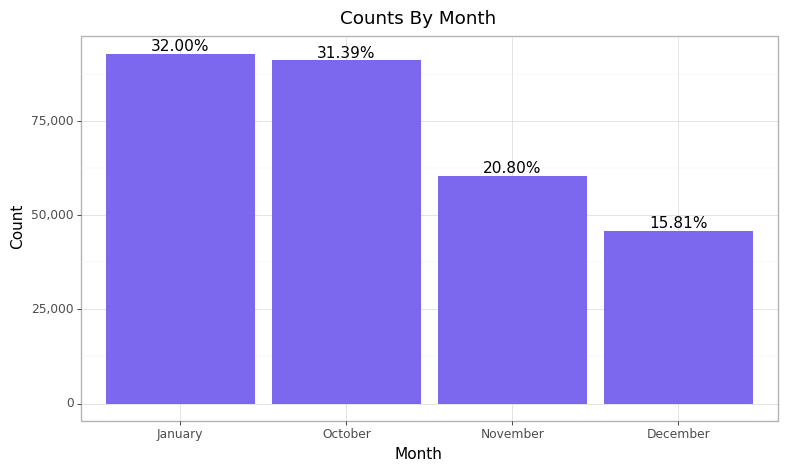

<ggplot: (-2140361175)>

In [34]:
custom.rec_count(train_c, "Month", rename_axis_text = ["January", "October", "November", "December"])

More PM2.5 recoders Where made in January 32% while December had the lowest record off PM2.5

##### Year

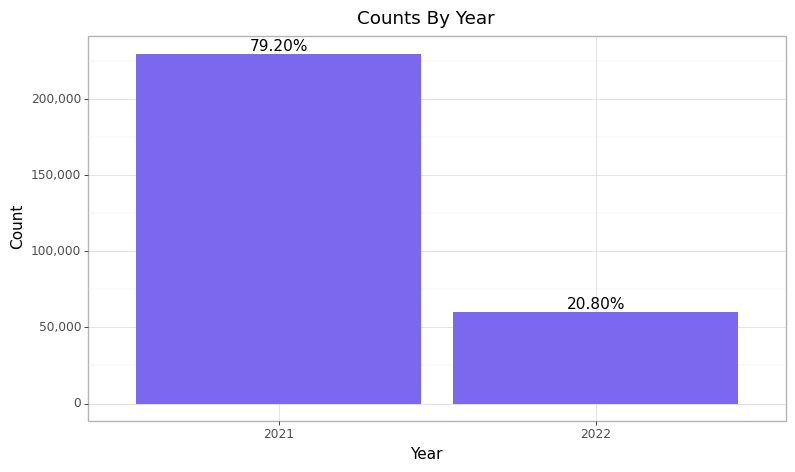

<ggplot: (-2134165701)>

In [35]:
custom.rec_count(train_c, "Year")

<a name="multi"><a/>
### Mulivarite Analysis
1. [Device Status and Particulate Matter](#dspm)
2. [Temperature, Relative_Humidity and Device status](#trhds)
3. [Air Quality with Temperature & Relative Humidity](#aqithr)

<a name="dspm"><a/>
#### Device Status and Particulate Matter 

In [36]:
f_color = ["#9B30FF", "#EE2C2C"]

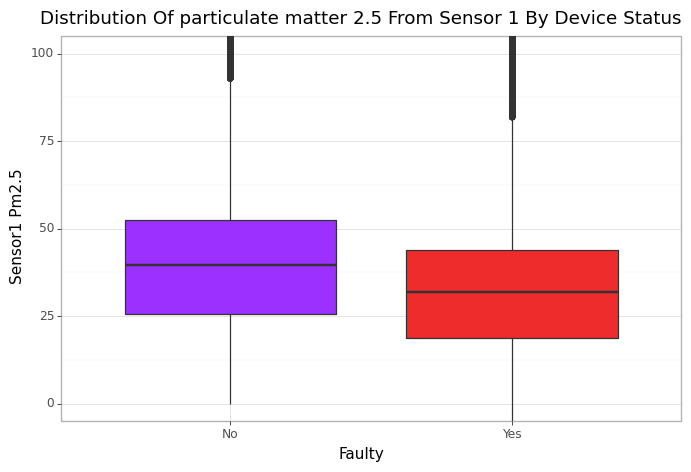

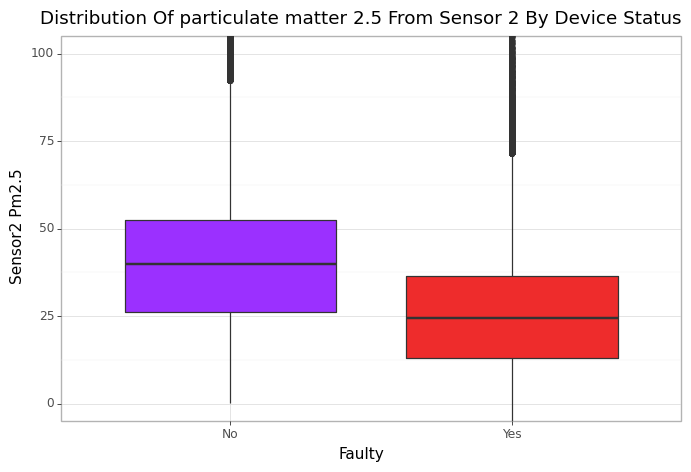

In [37]:
cols = ["Sensor1_PM2.5", "Sensor2_PM2.5"]
s_type = [1, 2]

for sensor, typ in zip(cols, s_type):
    print(custom.boxPlot(train_c, 
                         num_var = sensor, 
                         cat_var = "faulty",
                         color = f_color,
                         zoom = (0, 100),
                         title = [f"particulate matter 2.5 From Sensor {typ}", "Device Status"]))

In [38]:
dss_df = custom.vars_longer_summary(train_c, 
                                    select_vars = ["faulty", "Sensor1_PM2.5", "Sensor2_PM2.5"], 
                                    var_name = "Sensor", value_name = "PM 2.5", 
                                    replace_rec = ["Sensor 1", "Sensor 2"])
dss_df

,faulty,Sensor,mean,sum,median
0,No,Sensor 1,44.75738,8184467.89000,39.58000
1,No,Sensor 2,45.11564,8249981.49000,39.73000
2,Yes,Sensor 1,34.32256,3677697.16000,31.98000
3,Yes,Sensor 2,26.71986,2863059.27000,24.42000


In [39]:
summary_fun = ["sum", "median"]
plt_title = ["Total", "Median"]

for sumy_fun, plt_tl in zip(summary_fun, plt_title):
    custom.facet_summary_plot(df = dss_df, cat_var = "faulty", num_var = sumy_fun, fill = "faulty", facet_by = "Sensor", 
                               colors = f_color, ylab = "Particulate Matter",
                               title = f"{plt_tl} Particulate Matter In Each Sensor By Device Status")

<a name="trhds"><a/>
#### Temperature, Relative_Humidity and Device status

In [40]:
trh_df = custom.vars_longer_summary(train_c, 
                                      select_vars = ["faulty", "Temperature", "Relative_Humidity"],
                                      var_name  = "wether", value_name = "value")
trh_df

,faulty,wether,mean,sum,median
0,No,Relative_Humidity,78.63995,14380338.00000,84.00000
1,No,Temperature,23.31449,4263358.00000,21.90000
2,Yes,Relative_Humidity,78.57077,8418937.00000,84.00000
3,Yes,Temperature,23.33681,2500562.50000,22.00000


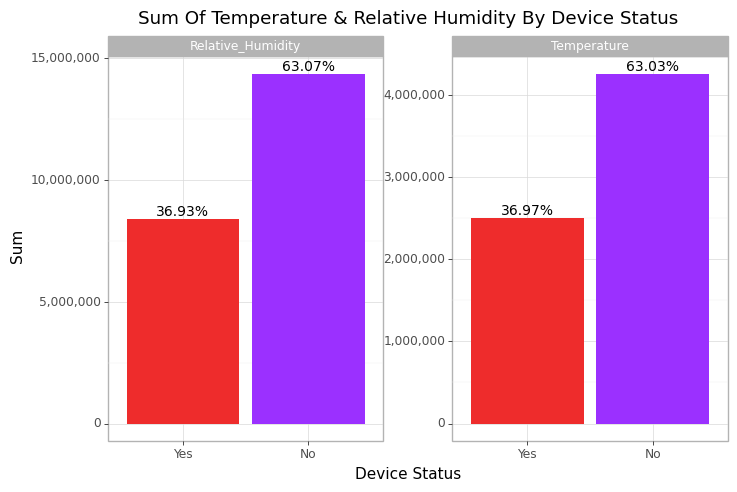

<ggplot: (-2147068101)>

In [41]:
custom.facet_summary_plot(df = trh_df, cat_var = "faulty", num_var = "sum", fill = "faulty", facet_by = "wether", scales = "free_y",
                          colors = f_color, title = "Sum Of Temperature & Relative Humidity By Device Status")

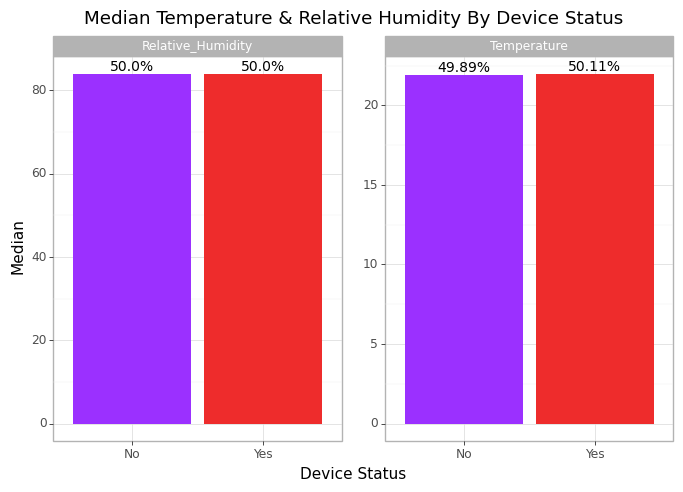

<ggplot: (420786)>

In [42]:
 custom.facet_summary_plot(df = trh_df, cat_var = "faulty", num_var = "median", fill = "faulty", facet_by = "wether",
                           scales = "free_y", sb_aj = 0.15, colors = f_color, 
                           title = "Median Temperature & Relative Humidity By Device Status")

<a name="aqithr"><a/>
#### Air Quality with Temperature & Relative Humidity

##### Air quality from Sensor 1

In [43]:
aqi1_thr_df =  custom.vars_longer_summary(train_c, 
                                          select_vars = ["S1_AQI", "Temperature", "Relative_Humidity"], 
                                          var_name    = "weather", 
                                          value_name  = "PM2.5")
aqi1_thr_df.head(3)

,S1_AQI,weather,mean,sum,median
0,Good,Relative_Humidity,65.90263,1627136.00000,65.00000
1,Good,Temperature,26.90797,664357.90000,27.60000
2,Hazardous,Relative_Humidity,58.08791,5286.00000,56.00000


In [44]:
trh_color = ["#87CEFA", "#CD853F"]

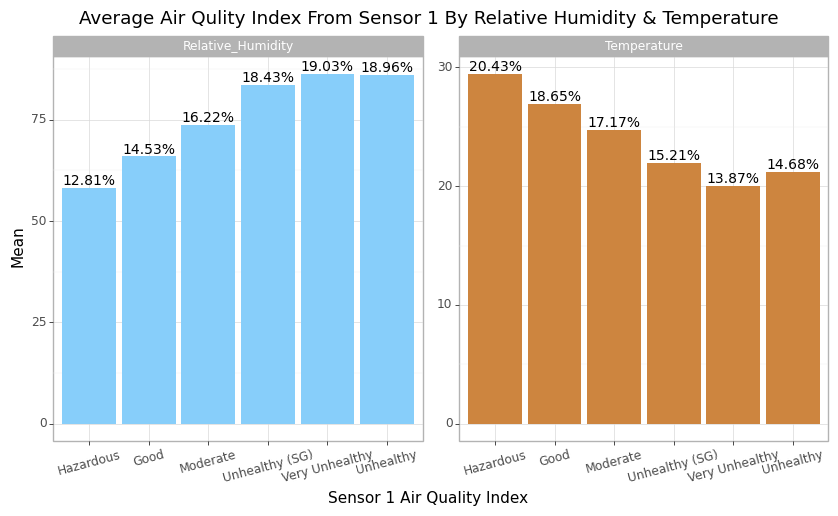

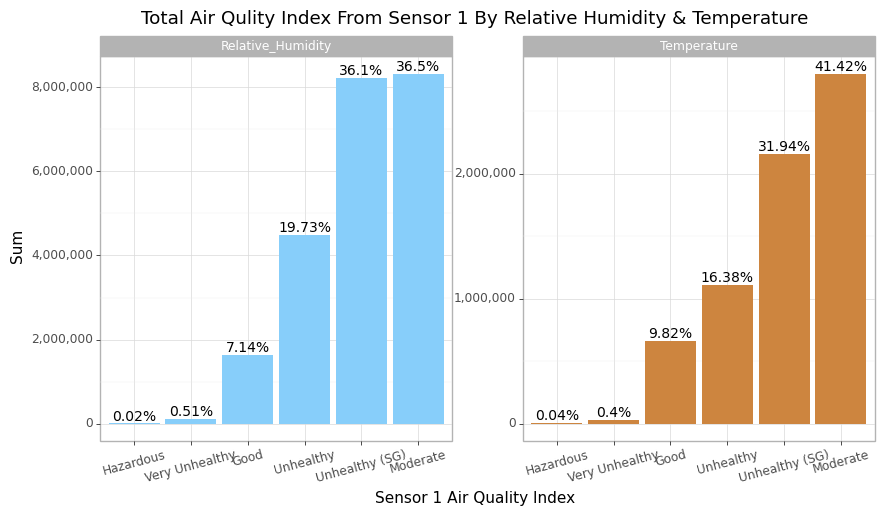

In [45]:
summary_fun = ["mean", "sum"]
plt_title = ["Average", "Total"]
sb_aj = [0.1, 0.20]

for sumy_fun, plt_tl, sub_aj in zip(summary_fun, plt_title, sb_aj):
    print(custom.facet_summary_plot(aqi1_thr_df, cat_var = "S1_AQI", num_var = sumy_fun, fill = "weather", facet_by = "weather", 
                                    scales = "free", sb_aj = sub_aj, plt_size = (10, 5), angle = 15, colors = trh_color,
                                    title = f"{plt_tl} Air Qulity Index From Sensor 1 By Relative Humidity & Temperature"))

##### Air quality from Sensor 2

In [46]:
aqi2_thr_df = custom.vars_longer_summary(train_c, 
                                         select_vars = ["S2_AQI", "Temperature", "Relative_Humidity"], 
                                         var_name    = "weather", 
                                         value_name  = "PM2.5")
aqi2_thr_df.head(3)

,S2_AQI,weather,mean,sum,median
0,Good,Relative_Humidity,66.62069,2294017.00000,65.00000
1,Good,Temperature,26.72261,920166.20000,27.50000
2,Hazardous,Relative_Humidity,56.25882,4782.00000,55.00000


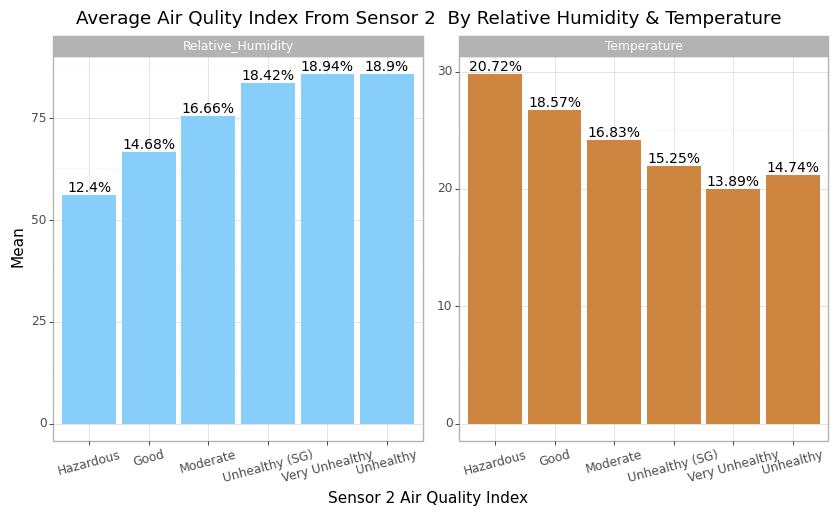

<ggplot: (19435024)>

In [47]:
custom.facet_summary_plot(aqi2_thr_df, cat_var = "S2_AQI", num_var = "mean", fill = "weather", facet_by = "weather", 
                           scales = "free", sb_aj = 0.1, plt_size = (10, 5), angle = 15, colors = trh_color,
                           title = "Average Air Qulity Index From Sensor 2  By Relative Humidity & Temperature")

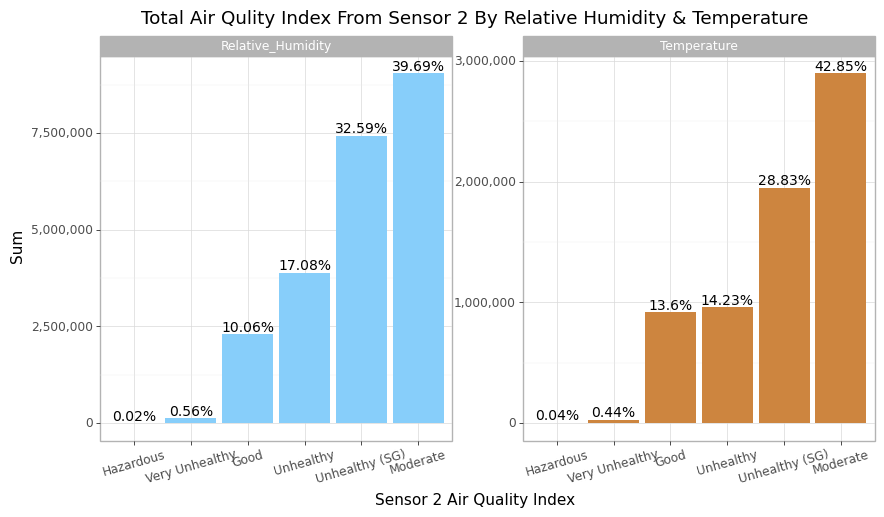

<ggplot: (-2125615057)>

In [48]:
custom.facet_summary_plot(aqi2_thr_df, cat_var = "S2_AQI", num_var = "sum", fill = "weather", facet_by = "weather", 
                           scales = "free", sb_aj = 0.20, plt_size = (10, 5), angle = 16, colors = trh_color,
                           title = "Total Air Qulity Index From Sensor 2 By Relative Humidity & Temperature")

<a name="corr"><a/>
### Correlation

<Figure size 1944x864 with 0 Axes>

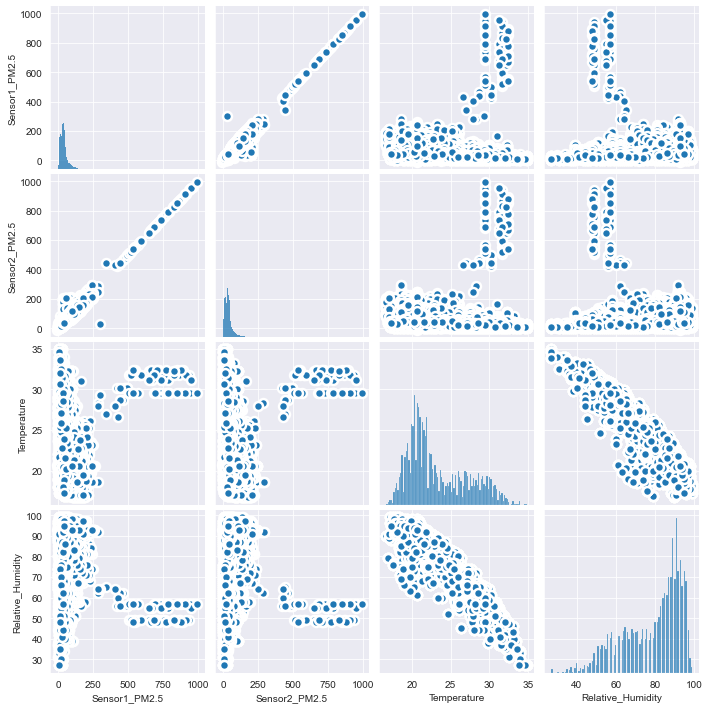

In [49]:
plt.figure(figsize = (27, 12))
num_cols = ['Sensor1_PM2.5', 'Sensor2_PM2.5', 'Temperature', 'Relative_Humidity']
sns.pairplot(train_c[num_cols], kind = "scatter", plot_kws = dict(s = 80, edgecolor = "white", linewidth = 2.5))
plt.show()

In [50]:
# Ordinal Encoding
corr_df = train_c.copy()

for col in ["S1_AQI", "S2_AQI"]:
    corr_df[col] = corr_df[col].replace({"Hazardous"     : 0, 
                                         "Very Unhealthy": 1, 
                                         "Unhealthy"     : 2, 
                                         "Unhealthy (SG)": 3, 
                                         "Moderate"      : 4, 
                                         "Good"          : 5})

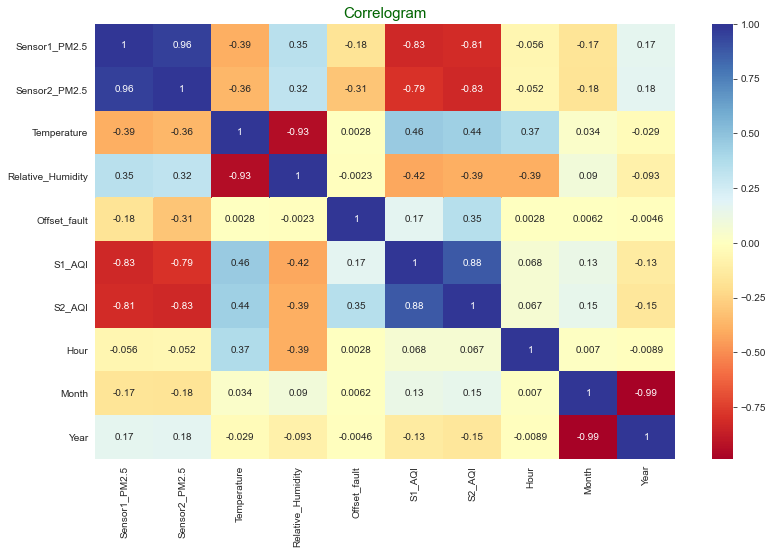

In [51]:
cor = corr_df.select_dtypes(["int64", "float64"]).corr()

plt.figure(figsize = (13, 8))
sns.heatmap(cor, cmap = 'RdYlBu', annot = True, center = 0)
plt.title('Correlogram', fontsize = 15, color = 'darkgreen')
plt.show()

The recorded PM2.5 from Sensor 1 is positively correlated with that of Sensor 2,  
Year, week of the year, day of the year, and month are all correlated.  
Air quality index(AQI) from both sensors are negatively correlated with the PM2.5.  
Temperature have a positive correlation with AQI while Relative Humidity have a negative correlation with AQI.

<a name="model"><a/>
## 8. Modelling

#### Additional Feature Engineering

In [52]:
# Ordinal Encoding on test set
to_replace = {"Hazardous"     : 0, 
              "Very Unhealthy": 1, 
              "Unhealthy"     : 2, 
              "Unhealthy (SG)": 3, 
              "Moderate"      : 4, 
              "Good"          : 5}

for col in ["S1_AQI", "S2_AQI"]:
    train_c[col] = train_c[col].replace(to_replace)
    test_c[col]  = test_c[col].replace(to_replace)

In [53]:
# linera model Imputation.
from sklearn.linear_model import LinearRegression
lr_reg = LinearRegression()

# spliting --------------------------------------------------------------------------------------
test_imp_df = test_c.loc[test_c["Temperature"].isnull() == True]
train_imp_df = test_c.loc[test_c["Temperature"].isnull() == False]

# Temperature
y_imp = train_imp_df["Temperature"]

X_imp_train = train_imp_df.drop(["ID", "Temperature", "Datetime", "Relative_Humidity"], axis = 1)
X_imp_test  = test_imp_df.drop(["ID", "Temperature", "Datetime", "Relative_Humidity"], axis = 1)

lr_reg.fit(X_imp_train, y_imp)
pred = lr_reg.predict(X_imp_test)

test_imp_df.loc[:, "Temperature"] = pred

# Relative Humidity
y_imp = train_imp_df["Relative_Humidity"]

X_imp_train = train_imp_df.drop(["ID", "Datetime", "Relative_Humidity"], axis = 1)
X_imp_test  = test_imp_df.drop(["ID", "Datetime", "Relative_Humidity"], axis = 1)


lr_reg.fit(X_imp_train, y_imp)
pred = lr_reg.predict(X_imp_test)

test_imp_df.loc[:, "Relative_Humidity"] = pred

test_c = pd.concat([train_imp_df, test_imp_df])

In [54]:
def downsample(df, random_state = 11):
    no  = df.loc[df["Offset_fault"] == 0]
    yes = df.loc[df["Offset_fault"] == 1]
    
    no_ds = resample(no, replace = False, n_samples = len(yes), random_state = 11)
    
    df_ds = pd.concat([no_ds, yes])
    return df_ds



def perform_cross_val(X_train, y_train, cv, rs = 11):
    kn_clf = KNeighborsClassifier()
    df_clf = DecisionTreeClassifier(random_state = rs)
    rf_clf = RandomForestClassifier(max_depth = 4, random_state= rs)
    
    mdl_name = ["KN classifier", "Decision Tree", "Random Forest"]
    mdl_clf = [kn_clf, df_clf, rf_clf]
    
    for name, model in zip(mdl_name, mdl_clf):
        clf_cv = cross_val_score(model, X_train, y_train, cv = cv, n_jobs = -1, scoring = 'accuracy')
        print(f"{name} :: {clf_cv.mean()}\n")
        
    
    
def evaluate_model(classifier, X_train, X_valid):
    y_pred_train = classifier.predict(X_train)
    y_pred_valid = classifier.predict(X_valid)
    
    print(f"Train Accuracy Score : {accuracy_score(y_train, y_pred_train)}\n")
    print(f"Train Confusion Metrix ::\n{confusion_matrix(y_train, y_pred_train)}")
    print()
    
    print("-"*55,"\n")
    
    print(f"Test Accuracy Score : {accuracy_score(y_valid, y_pred_valid)}\n")
    print(f"Test Confusion Metrix ::\n{confusion_matrix(y_valid, y_pred_valid)}\n")
    print("Test classification Report ::\n", classification_report(y_valid, y_pred_valid))


# Cross Validation
def kfold_CV(mdl, X, y, k = 5, rs = 11):
    CV = KFold(n_splits = k, random_state = rs, shuffle = True)

    scores = cross_val_score(mdl, X, y, scoring = 'accuracy', cv = CV, n_jobs = -1)
    
    return print(f"Average accuracy score :: {np.mean(scores)}")

In [55]:
train_ds = downsample(train_c)

features = ['Sensor1_PM2.5', 'Sensor2_PM2.5', 'Temperature', 'Relative_Humidity', 'S1_AQI', 'S2_AQI']
X = train_ds[features]
y = train_ds["Offset_fault"]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3, shuffle = True, random_state = 11)

In [56]:
X_train.shape, X_valid.shape

((150011, 6), (64291, 6))

In [57]:
# finding the Best Classifier
perform_cross_val(X_train, y_train, 5)

KN classifier :: 0.9331515860702

Decision Tree :: 0.901367252782088

Random Forest :: 0.7737298571989345



It seem KNeighbors and DecisionTree models are overfitting the data.

### RandomForest

In [58]:
rf_clf = RandomForestClassifier(random_state = 111)
kfold_CV(rf_clf, X_train, y_train)

Average accuracy score :: 0.9401443781137964


The random Forest model shows a sign of overfitting.

In [59]:
# Fine-Tuning The RandomForest Model

params = {"max_depth": [3, 4, 5],
          "n_estimators": [50, 100, 150],
          "min_samples_split": [5, 6, 7]}

grid_search = GridSearchCV(estimator = rf_clf, 
                           param_grid = params, 
                           cv = 4, 
                           n_jobs= -1, 
                           scoring = "accuracy")

rf_best_mdl = grid_search.fit(X_train, y_train)

rf_best_mdl.best_estimator_

RandomForestClassifier(max_depth=5, min_samples_split=7, n_estimators=50,
                       random_state=111)

In [60]:
rf_best_clf = RandomForestClassifier(max_depth = 5, min_samples_split = 7, n_estimators = 50, random_state = 111)

kfold_CV(rf_best_clf, X_train, y_train)

Average accuracy score :: 0.8181533485431093


<a name="testing"><a/>
## Testing 

In [61]:
X_test = test_c[features]

In [62]:
rf_best_clf = RandomForestClassifier(max_depth = 5, min_samples_split = 7, n_estimators = 50, random_state = 111)
# knn_clf_final.fit(X_full_train, y)
rf_best_clf.fit(X, y)

y_pred = rf_best_clf.predict(X)

# Measuring the accuracy of the model
print(f'Accuracy score: {accuracy_score(y, y_pred)}\n')
print(f'{classification_report(y, y_pred)}')

Accuracy score: 0.8101650941195135

              precision    recall  f1-score   support

           0       0.81      0.82      0.81    107151
           1       0.81      0.80      0.81    107151

    accuracy                           0.81    214302
   macro avg       0.81      0.81      0.81    214302
weighted avg       0.81      0.81      0.81    214302



In [63]:
y_pred_test = rf_best_clf.predict(X_test)

# Measuring the accuracy of the model
print(f"Accuracy score: {accuracy_score(samplesubmission['Offset_fault'], y_pred_test)}\n")
print(f"Confusion Metrix :\n{confusion_matrix(samplesubmission['Offset_fault'], y_pred_test)}\n")
print(f"classification_report :\n{classification_report(samplesubmission['Offset_fault'], y_pred_test)}")

Accuracy score: 0.7558122188110961

Confusion Metrix :
[[96261 31100]
 [    0     0]]

classification_report :
              precision    recall  f1-score   support

           0       1.00      0.76      0.86    127361
           1       0.00      0.00      0.00         0

    accuracy                           0.76    127361
   macro avg       0.50      0.38      0.43    127361
weighted avg       1.00      0.76      0.86    127361



In [64]:
samplesubmission.to_csv("sampleSubmissionPrediction.csv")